Read the outlier-removed df.

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

train_data = pd.read_csv("UsedCarSellingInfoCraigslist_OutlierRemoved.csv")

Let's drop 'Unnamed: 0'.

In [2]:
train_data.drop(['Unnamed: 0'], axis = 1, inplace=True)
#train_data.head()

Let's makes features as X and target as y.

In [3]:
X = train_data.drop('price', axis=1)
y = train_data['price'].values

# Split train test data

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Gradient Boost Regressor

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

# CART Gradient Boost Feature Importance

In [7]:
from matplotlib import pyplot as plt

Feature: 1, Score: 0.16573
Feature: 4, Score: 0.18730
Feature: 56, Score: 0.18348
Feature: 59, Score: 0.06249
Feature: 70, Score: 0.14577


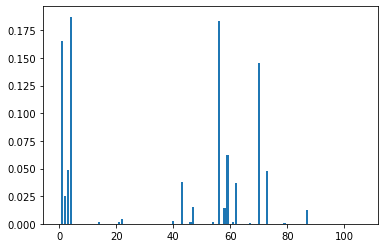

Wall time: 1.45 s


<Figure size 432x288 with 0 Axes>

In [8]:
%%time
# get importance
importance = gb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if v >= 0.05:
        print('Feature: %0d, Score: %.5f' % (i,v))
        
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();
plt.savefig('gradientboostregressor_feature_importance.png');

Let's reduce number of features within meaningful range, more than 0.05 only.

Let's makes NEW features as X1.

In [9]:
X_train.columns[[1,4,56,70,72]]

Index(['odometer', 'usage_yr', 'division_Middle Atlantic',
       'manufacturer_cadillac', 'manufacturer_chevrolet'],
      dtype='object')

Let's reduce number of features within meaningful range, more than 0.05 only.

In [10]:
X1 = train_data[['odometer', 'usage_yr', 'division_Middle Atlantic','manufacturer_cadillac', 'manufacturer_chevrolet']]

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=42)

In [12]:
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [13]:
%time
from sklearn.model_selection import RandomizedSearchCV
params = {'loss' :['ls', 'lad', 'huber', 'quantile'],
          'criterion' :['friedman_mse', 'mse', 'mae'],
          'n_estimators' : [120,300,500,800,1200],
          'max_depth' : [5,8,15,25,30,None],
          'min_samples_split' : [2,5,10,15,100],
          'min_samples_leaf' : [1,2,5,10],          
          'max_features' : ['auto', 'sqrt', 'log2', None]}
random_search_cv = RandomizedSearchCV(gb, params, n_jobs=-1, verbose=2, n_iter=2, cv=2)
random_search_cv.fit(X_train, y_train)
print("R-Squared::{}".format(random_search_cv.best_score_))
print("Best Hyperparameters::\n{}".format(random_search_cv.best_params_))

Wall time: 0 ns
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 26.7min remaining: 26.7min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 112.4min finished


R-Squared::-0.30837667790585555
Best Hyperparameters::
{'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 25, 'loss': 'ls', 'criterion': 'friedman_mse'}


In [20]:
from sklearn import ensemble

In [15]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [17]:
params_ = {'n_estimators': 300, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'sqrt', 
          'max_depth': 25, 'loss': 'ls', 'criterion': 'friedman_mse'}

In [23]:
reg = ensemble.GradientBoostingRegressor(**params_)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 94587999251105.3594


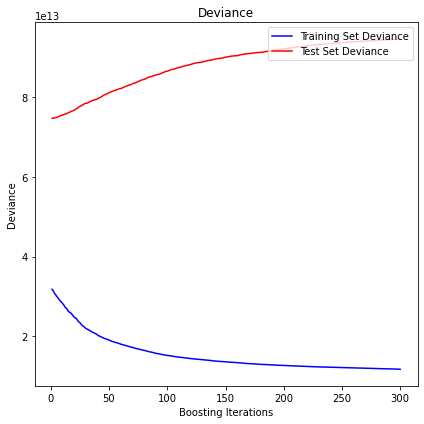

In [24]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [25]:
plt.savefig('gradientboost1.png')

<Figure size 432x288 with 0 Axes>

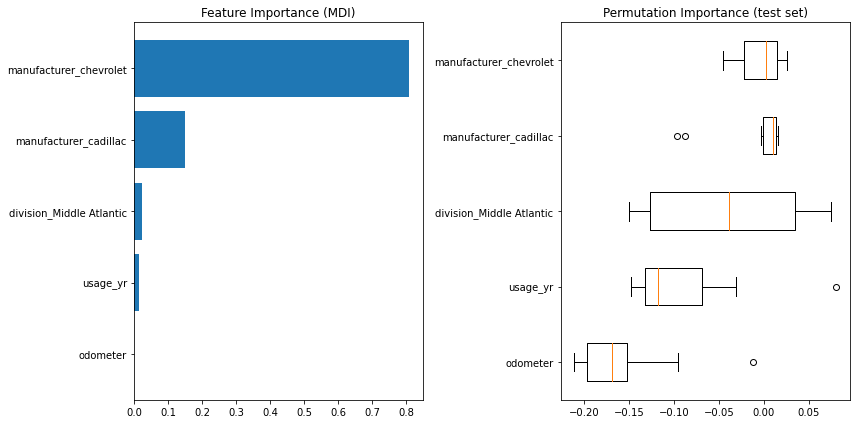

In [33]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, ['odometer', 'usage_yr', 'division_Middle Atlantic','manufacturer_cadillac', 'manufacturer_chevrolet'])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=['odometer', 'usage_yr', 'division_Middle Atlantic','manufacturer_cadillac', 'manufacturer_chevrolet'])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [34]:
plt.savefig('gradientboost2.png')

<Figure size 432x288 with 0 Axes>